# **Graph Neural Networks for End-to-End Particle Identification with the CMS Experiment Task-2**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [1]:
import numpy as np
from tqdm import tqdm
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt

In [2]:
# Modules for pytorch model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

## Model - PyTorch CNN

### Creating Custom Dataset

In [3]:
class MyDataset(Dataset):

    """
    Custom dataset for Image dataset
    """

    def __init__(self, split = 'train', test_size = 0.2):

      filename = '/content/drive/MyDrive/GSOC/Quark-gluon using cnn/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet'
      self.parquet_file = pq.ParquetFile(filename)

      num_rows = self.parquet_file.metadata.num_rows

      indices = np.arange(num_rows)
      train, test = train_test_split(indices, test_size = test_size, stratify = np.array(self.parquet_file.read(columns = 'y')).reshape(-1))

      if split == 'train':
        data = self.parquet_file.read_row_groups(sorted(train), columns = ['X_jets', 'y'])
        self.X = torch.tensor(data.column('X_jets').to_pylist())
        self.y = torch.tensor(data.column('y').to_pylist()).long()
  
      else:
        data = self.parquet_file.read_row_groups(sorted(test), columns = ['X_jets', 'y'])
        self.X = torch.tensor(data.column('X_jets').to_pylist())
        self.y = torch.tensor(data.column('y').to_pylist()).long()

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]
      

In [4]:
train_dataset = MyDataset(split='train')
test_dataset = MyDataset(split='test')

In [5]:
len(train_dataset)

29017

### Data Loaders

In [6]:
def get_data_loaders(train_dataset, test_dataset, batch_size=32):

    """
    Function to create the DataLoaders for train-val-test data. 
    Can specify batch size. Default value is set to 32.
    """

    # Shuffle=True for training data to get diversity in batches at each training epoch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory = True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory = True)

    return train_loader, test_loader

train_loader, test_loader = get_data_loaders(train_dataset, test_dataset, batch_size=360)

Set Device

In [7]:
def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device = get_device()
print(device)

cuda


### Model Architecture

1. Simple vanilla CNN architecture with 2 Conv aand 2 Linear layers.
2. 2 conv-->relu-->pool blocks flattened and followed by linear-->relu-->linear.

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 31 * 31, 120)
        self.fc2 = nn.Linear(120, 2)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 32 * 31 * 31)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


Setup - 
1. Model Creation
2. Setting Adam optimizer with learning rate scheduler
3. Defining CrossEntropyLoss function

In [33]:
# Model
model_pytorch = Net()
model_pytorch = model_pytorch.to(device)

# Optimizer and Learning Rate Scheduler

optimizer = optim.Adam(model_pytorch.parameters(), lr=5e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# Loss Function

criterion = torch.nn.CrossEntropyLoss()

In [34]:
print(model_pytorch)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=30752, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=2, bias=True)
)


### Training

In [37]:
def train(model, device, loader, optimizer, criterion, scheduler):

    model.train()

    y_true = []
    y_probas = []

    for data in tqdm(loader):  # Iterate in batches over the training dataset.
        
        X, y = data
        X = X.to(device)
        y = y.to(device)

        out = model(X)  # Perform a single forward pass.

        loss = criterion(out, y.squeeze())  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

        y_true += y.cpu().numpy().tolist()
        y_probas += out[:, 1].detach().cpu().numpy().tolist()  # probability of class 1

    scheduler.step()

    fpr, tpr, thresholds = roc_curve(y_true, y_probas)
    roc_auc = auc(fpr, tpr)

    lr = optimizer.param_groups[0]['lr']
    print(f'Train AUC : {roc_auc:.3f}, learning rate: {lr:.6f}')

    return model

    
def evaluate(model, device, loader):

    model.eval()

    y_true = []
    y_probas = []

    with torch.no_grad():
      
        for data in tqdm(loader):

            X, y = data

            X = X.to(device)
            y = y.to(device)
            
            out = model(X)        
            
            y_true += y.cpu().numpy().tolist()
            y_probas += out[:, 1].cpu().numpy().tolist()  # probability of class 1

    # Calculating few metrics

        fpr, tpr, thresholds = roc_curve(y_true, y_probas)
        roc_auc = auc(fpr, tpr)

        print(f'Test AUC : {roc_auc:.3f}\n')



In [38]:
# Training Loop

epochs = 30

for epoch in range(epochs):

  print(f'Epoch : {epoch+1} \n')

  model_pytorch = train(model_pytorch, device, train_loader, optimizer, criterion, scheduler)
  evaluate(model_pytorch, device, test_loader)

Epoch : 1 



100%|██████████| 81/81 [00:02<00:00, 28.35it/s]


Train AUC : 0.694, learning rate: 0.000500


100%|██████████| 21/21 [00:00<00:00, 38.78it/s]


Test AUC : 0.757

Epoch : 2 



100%|██████████| 81/81 [00:02<00:00, 28.49it/s]


Train AUC : 0.756, learning rate: 0.000500


100%|██████████| 21/21 [00:00<00:00, 39.60it/s]


Test AUC : 0.782

Epoch : 3 



100%|██████████| 81/81 [00:02<00:00, 28.39it/s]


Train AUC : 0.781, learning rate: 0.000500


100%|██████████| 21/21 [00:00<00:00, 38.57it/s]


Test AUC : 0.801

Epoch : 4 



100%|██████████| 81/81 [00:02<00:00, 27.74it/s]


Train AUC : 0.795, learning rate: 0.000500


100%|██████████| 21/21 [00:00<00:00, 39.36it/s]


Test AUC : 0.815

Epoch : 5 



100%|██████████| 81/81 [00:02<00:00, 27.12it/s]


Train AUC : 0.809, learning rate: 0.000500


100%|██████████| 21/21 [00:00<00:00, 38.79it/s]


Test AUC : 0.824

Epoch : 6 



100%|██████████| 81/81 [00:02<00:00, 28.13it/s]


Train AUC : 0.823, learning rate: 0.000500


100%|██████████| 21/21 [00:00<00:00, 39.65it/s]


Test AUC : 0.832

Epoch : 7 



100%|██████████| 81/81 [00:02<00:00, 28.37it/s]


Train AUC : 0.836, learning rate: 0.000500


100%|██████████| 21/21 [00:00<00:00, 39.78it/s]


Test AUC : 0.842

Epoch : 8 



100%|██████████| 81/81 [00:02<00:00, 28.26it/s]


Train AUC : 0.851, learning rate: 0.000500


100%|██████████| 21/21 [00:00<00:00, 40.52it/s]


Test AUC : 0.857

Epoch : 9 



100%|██████████| 81/81 [00:02<00:00, 28.48it/s]


Train AUC : 0.868, learning rate: 0.000500


100%|██████████| 21/21 [00:00<00:00, 39.96it/s]


Test AUC : 0.871

Epoch : 10 



100%|██████████| 81/81 [00:02<00:00, 28.46it/s]


Train AUC : 0.887, learning rate: 0.000250


100%|██████████| 21/21 [00:00<00:00, 40.13it/s]


Test AUC : 0.885

Epoch : 11 



100%|██████████| 81/81 [00:02<00:00, 28.46it/s]


Train AUC : 0.916, learning rate: 0.000250


100%|██████████| 21/21 [00:00<00:00, 39.65it/s]


Test AUC : 0.904

Epoch : 12 



100%|██████████| 81/81 [00:02<00:00, 27.63it/s]


Train AUC : 0.932, learning rate: 0.000250


100%|██████████| 21/21 [00:00<00:00, 39.50it/s]


Test AUC : 0.913

Epoch : 13 



100%|██████████| 81/81 [00:02<00:00, 28.03it/s]


Train AUC : 0.944, learning rate: 0.000250


100%|██████████| 21/21 [00:00<00:00, 39.64it/s]


Test AUC : 0.922

Epoch : 14 



100%|██████████| 81/81 [00:02<00:00, 27.96it/s]


Train AUC : 0.956, learning rate: 0.000250


100%|██████████| 21/21 [00:00<00:00, 40.04it/s]


Test AUC : 0.925

Epoch : 15 



100%|██████████| 81/81 [00:02<00:00, 28.32it/s]


Train AUC : 0.967, learning rate: 0.000250


100%|██████████| 21/21 [00:00<00:00, 39.75it/s]


Test AUC : 0.934

Epoch : 16 



100%|██████████| 81/81 [00:02<00:00, 28.10it/s]


Train AUC : 0.975, learning rate: 0.000250


100%|██████████| 21/21 [00:00<00:00, 39.64it/s]


Test AUC : 0.942

Epoch : 17 



100%|██████████| 81/81 [00:02<00:00, 28.37it/s]


Train AUC : 0.984, learning rate: 0.000250


100%|██████████| 21/21 [00:00<00:00, 40.12it/s]


Test AUC : 0.946

Epoch : 18 



100%|██████████| 81/81 [00:02<00:00, 28.38it/s]


Train AUC : 0.989, learning rate: 0.000250


100%|██████████| 21/21 [00:00<00:00, 40.06it/s]


Test AUC : 0.949

Epoch : 19 



100%|██████████| 81/81 [00:02<00:00, 27.46it/s]


Train AUC : 0.993, learning rate: 0.000250


100%|██████████| 21/21 [00:00<00:00, 39.62it/s]


Test AUC : 0.951

Epoch : 20 



100%|██████████| 81/81 [00:02<00:00, 28.19it/s]


Train AUC : 0.995, learning rate: 0.000125


100%|██████████| 21/21 [00:00<00:00, 39.76it/s]


Test AUC : 0.950

Epoch : 21 



100%|██████████| 81/81 [00:02<00:00, 28.30it/s]


Train AUC : 0.998, learning rate: 0.000125


100%|██████████| 21/21 [00:00<00:00, 40.09it/s]


Test AUC : 0.954

Epoch : 22 



100%|██████████| 81/81 [00:02<00:00, 28.28it/s]


Train AUC : 0.998, learning rate: 0.000125


100%|██████████| 21/21 [00:00<00:00, 39.88it/s]


Test AUC : 0.954

Epoch : 23 



100%|██████████| 81/81 [00:02<00:00, 27.33it/s]


Train AUC : 0.999, learning rate: 0.000125


100%|██████████| 21/21 [00:00<00:00, 39.87it/s]


Test AUC : 0.954

Epoch : 24 



100%|██████████| 81/81 [00:02<00:00, 28.35it/s]


Train AUC : 0.999, learning rate: 0.000125


100%|██████████| 21/21 [00:00<00:00, 39.79it/s]


Test AUC : 0.954

Epoch : 25 



100%|██████████| 81/81 [00:02<00:00, 28.26it/s]


Train AUC : 0.999, learning rate: 0.000125


100%|██████████| 21/21 [00:00<00:00, 39.64it/s]


Test AUC : 0.955

Epoch : 26 



100%|██████████| 81/81 [00:02<00:00, 27.37it/s]


Train AUC : 0.999, learning rate: 0.000125


100%|██████████| 21/21 [00:00<00:00, 40.14it/s]


Test AUC : 0.955

Epoch : 27 



100%|██████████| 81/81 [00:02<00:00, 28.55it/s]


Train AUC : 0.999, learning rate: 0.000125


100%|██████████| 21/21 [00:00<00:00, 39.71it/s]


Test AUC : 0.954

Epoch : 28 



100%|██████████| 81/81 [00:02<00:00, 28.40it/s]


Train AUC : 0.999, learning rate: 0.000125


100%|██████████| 21/21 [00:00<00:00, 40.01it/s]


Test AUC : 0.955

Epoch : 29 



100%|██████████| 81/81 [00:02<00:00, 28.30it/s]


Train AUC : 0.999, learning rate: 0.000125


100%|██████████| 21/21 [00:00<00:00, 39.77it/s]


Test AUC : 0.955

Epoch : 30 



100%|██████████| 81/81 [00:02<00:00, 28.39it/s]


Train AUC : 1.000, learning rate: 0.000063


100%|██████████| 21/21 [00:00<00:00, 40.43it/s]

Test AUC : 0.956



### Testing

In [39]:
def test(model, device, loader):
  
    model.eval()
    y_true = []
    y_probas = []
    y_pred = []

    with torch.no_grad():
      
        for data in tqdm(loader):
          
            X, y = data

            X = X.to(device)
            y = y.to(device)
            
            out = model(X)
            
            y_true += y.cpu().numpy().tolist()
            y_pred += out.argmax(dim=1).cpu().numpy().tolist()  # absoulte predictions
            y_probas += out[:, 1].cpu().numpy().tolist()  # probability of class 1

    # Calculating few metrics

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_probas)
    roc_auc = auc(fpr, tpr)

    print('\nResults\n')
    print(f'Testing Accuracy {acc:.3f}')
    print(f'F1 score: {f1:.3f}')
    print(f'ROC-AUC: {roc_auc:.4f}\n')

    return acc, f1, fpr, tpr, roc_auc

In [40]:
acc_pytorch, f1_pytorch, fpr_pytorch, tpr_pytorch, auc_pytorch = test(model_pytorch, device, test_loader)

100%|██████████| 21/21 [00:00<00:00, 37.95it/s]


Results

Testing Accuracy 0.935
F1 score: 0.935
ROC-AUC: 0.9558



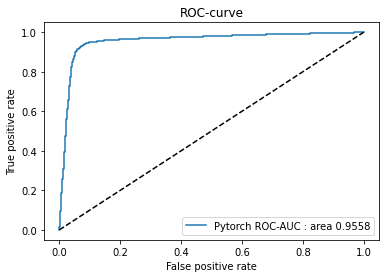

In [41]:
plt.plot(fpr_pytorch, tpr_pytorch, label=f'Pytorch ROC-AUC : area {auc_pytorch:.4f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC-curve')

plt.legend()
#plt.savefig('roc-auc.png')
plt.show()